In [1]:
import warnings
import logging
warnings.filterwarnings("ignore")

In [2]:
import copy
import datetime
import glob
import warnings
from functools import lru_cache, partial
from pprint import pprint

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import torch

from gym_trading_env.renderer import Renderer
from IPython.display import display
from environments.environments import NeuralForecastingTradingEnv
# from ray import train, tune
from tqdm.autonotebook import tqdm
from utils.utils import build_market_image

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import Dict, Tuple
from pprint import pprint

from neuralforecast.core import NeuralForecast
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.appo import APPOConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.algorithms.dreamerv3 import DreamerV3Config
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.evaluation.metrics import summarize_episodes
from ray.rllib.evaluation.worker_set import WorkerSet
from ray.rllib.policy import Policy
from ray.tune import JupyterNotebookReporter
from ray.tune.logger import pretty_print
from ray.tune.registry import register_env
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search.optuna import OptunaSearch

2024-05-28 08:34:57,953	WARNING deprecation.py:50 -- DeprecationWarning: `WorkerSet` has been deprecated. Use `ray.rllib.env.env_runner_group.EnvRunnerGroup` instead. This will raise an error in the future!


In [3]:
import os

In [4]:
%%writefile custom.css
/* custom.css */

/* Set background color for all widgets */
.tuneStatus {
    /* white background */
    background-color: #ffffff;
    
    width: 100%;
    height: 100%;
    overflow:'auto',
    transition:'all'
}

Overwriting custom.css


In [5]:
from IPython.display import display, HTML
import tensorboard

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">') # make sure the path is correct, it fails silently otherwise
display(css)

In [6]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT',
            'ETH/BTC','SOL/ETH','BNB/ETH','XRP/ETH',"ADA/ETH",
            'SOL/BTC','SOL/BNB',
            'XRP/BTC','XRP/BNB',
            'ADA/BTC','ADA/BNB',
            ]
target_pair='ETHUSDT'
time_frame="1h"

In [7]:
model=NeuralForecast.load("forecasting_model/")

Seed set to 5
Seed set to 11
Seed set to 17
Seed set to 6


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:

symbol='ETH/USDT'
data=build_market_image(target_pair=symbol,time_frame='1h',axis=0)
data=data[data['symbol']==target_pair.replace('/','')].copy()
data['ds']=data.index



In [10]:
split_date=datetime.datetime(year= 2024, month= 3, day=1)
end_date=split_date+datetime.timedelta(days=14)

symbol='ETHUSDT'
hf_data=data.copy()

hf_train_data=hf_data.groupby('symbol').apply(lambda x: x[:split_date])
hf_test_data=hf_data.groupby('symbol').apply(lambda x: x[split_date:end_date])

hf_train_data=hf_train_data.reset_index(level=0,drop=True).reset_index()
hf_test_data=hf_test_data.reset_index(level=0,drop=True).reset_index()


trade_data=data[data['symbol']==symbol].copy()
train_data=trade_data[:split_date]
test_data=trade_data[split_date:end_date]
# hf_test_data

In [11]:
train_data.head(5)

,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,...,feature_log_volume_15,feature_log_return_20,feature_log_volume_20,feature_log_return_25,feature_log_volume_25,feature_log_return_30,feature_log_volume_30,ds,unique_id,symbol
date_close,,,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,3723.884414,3729.197344,3710.322727,3715.714373,19.49929,3715.714373,0.434783,0.833333,0.0,0.001374,...,0.503824,0.5921,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 10:00:00,8,ETHUSDT
2022-01-01 11:00:00,3716.944414,3730.627344,3674.772727,3698.394373,62.84954,3698.394373,0.478261,0.833333,0.0,0.001374,...,0.503824,0.5921,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 11:00:00,8,ETHUSDT
2022-01-01 12:00:00,3690.994414,3711.027344,3691.002727,3691.794373,24.00284,3691.794373,0.521739,0.833333,0.0,0.001374,...,0.503824,0.5921,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 12:00:00,8,ETHUSDT
2022-01-01 13:00:00,3696.344414,3716.927344,3695.222727,3716.934373,15.28388,3716.934373,0.565217,0.833333,0.0,0.001374,...,0.503824,0.5921,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 13:00:00,8,ETHUSDT
2022-01-01 14:00:00,3716.244414,3723.947344,3707.892727,3709.724373,27.37488,3709.724373,0.608696,0.833333,0.0,0.001374,...,0.503824,0.5921,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 14:00:00,8,ETHUSDT


In [12]:
def prep_forecasts(df):
    forecast_array=[]
    # print(self.df.columns)

    model.dataset, model.uids, model.last_dates, model.ds=model._prepare_fit(df[['ds','unique_id','y']],
                                                                                        static_df=None, 
                                                                                        sort_df=None,
                                                                                        predict_only=False,
                                                                                        id_col='unique_id', 
                                                                                        time_col='ds', 
                                                                                        target_col='y')
    forecasts=model.predict_insample()
    forecasts_series=forecasts.groupby('cutoff').apply(lambda x: x.select_dtypes(np.number).values.flatten())
    new_df=df[df['ds'].isin([c for c in forecasts_series.index])]
    forecasts_series=forecasts_series[new_df.index]
    forecast_array=[c for c in forecasts_series]
    return forecast_array,new_df

In [13]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']="1"
train_forecast_array,train_df=prep_forecasts(train_data)
test_forecast_array,test_df=prep_forecasts(test_data)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
def rew_func(history):
    portfolio_initial_value= history["portfolio_valuation",0]
    current_position=history['position',-1]
    portfolio_return=history["portfolio_valuation"]
    portfolio_pct_change=pd.Series(np.array(portfolio_return)).pct_change().fillna(0)
    # print(portfolio_pct_change)
    reward = (portfolio_pct_change.mean() / portfolio_pct_change.std())
    
    # print(np.isnan(reward),reward)
    reward = 0 if np.isnan(reward) else reward
    # print(np.isnan(reward),reward)
    return float(reward)


In [15]:
train_env_config=dict(
                name='ETHUSDT_train',
                forecast_horizon=7,
                context_length=35,
                reward_function=rew_func,
                forecasts=train_forecast_array,
                df = train_df, # Your dataset with your custom features
                positions = [ -.5,-.25,.25, .5], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
                trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
                borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
                max_episode_duration=168,
                verbose=0
                )

test_env_config=copy.deepcopy(train_env_config)
test_env_config['name']='ETHUSDT_test'
test_env_config['df'] = test_df
test_env_config['forecasts']=test_forecast_array



In [16]:
train_env=NeuralForecastingTradingEnv(**train_env_config)

In [17]:
obs,info=train_env.reset()
obs.shape

(53,)

In [18]:
train_env.df.tail(5)

,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,...,feature_log_volume_20,feature_log_return_25,feature_log_volume_25,feature_log_return_30,feature_log_volume_30,ds,unique_id,symbol,dynamic_feature__0,dynamic_feature__1
date_close,,,,,,,,,,,,,,,,,,,,,
2022-01-01 10:00:00,3723.884414,3729.197344,3710.322727,3715.714373,19.49929,3715.714373,0.434783,0.833333,0.000000,0.001374,...,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 10:00:00,8,ETHUSDT,0,0
2022-01-01 11:00:00,3716.944414,3730.627344,3674.772727,3698.394373,62.84954,3698.394373,0.478261,0.833333,0.000000,0.001374,...,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 11:00:00,8,ETHUSDT,0,0
2022-01-01 12:00:00,3690.994414,3711.027344,3691.002727,3691.794373,24.00284,3691.794373,0.521739,0.833333,0.000000,0.001374,...,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 12:00:00,8,ETHUSDT,0,0
2022-01-01 13:00:00,3696.344414,3716.927344,3695.222727,3716.934373,15.28388,3716.934373,0.565217,0.833333,0.000000,0.001374,...,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 13:00:00,8,ETHUSDT,0,0
2022-01-01 14:00:00,3716.244414,3723.947344,3707.892727,3709.724373,27.37488,3709.724373,0.608696,0.833333,0.000000,0.001374,...,0.559676,0.555939,0.505669,0.610735,0.486693,2022-01-01 14:00:00,8,ETHUSDT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 14:00:00,3462.814414,3488.487344,3449.642727,3480.784373,34.33860,3480.784373,0.608696,0.500000,0.933333,0.163017,...,-1.721667,0.605415,0.714148,0.670463,0.859290,2024-02-29 14:00:00,8,ETHUSDT,0,0
2024-02-29 15:00:00,3479.914414,3495.377344,3451.662727,3465.994373,25.14060,3465.994373,0.652174,0.500000,0.933333,0.163017,...,-1.320043,0.592298,-0.103815,0.650256,-0.733422,2024-02-29 15:00:00,8,ETHUSDT,0,0
2024-02-29 16:00:00,3469.244414,3485.967344,3457.842727,3467.064373,46.05730,3467.064373,0.695652,0.500000,0.933333,0.163017,...,-0.025199,0.587787,0.288850,0.641973,0.421953,2024-02-29 16:00:00,8,ETHUSDT,0,0


In [19]:
obs=train_env.reset()
terminated = truncated = False
# env.action_space.sa
while not terminated and not truncated:
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
info['reward']
train_env.results_metrics
info

{'idx': 4881,
 'step': 167,
 'date': numpy.datetime64('2022-07-23T19:00:00.000000000'),
 'position_index': 1,
 'position': -0.25,
 'real_position': -0.2455459422529789,
 'data_volume': 1143.6312898635122,
 'data_open': 1500.9044144229583,
 'data_ds': Timestamp('2022-07-23 19:00:00'),
 'data_y': 1498.4943733109976,
 'data_low': 1488.2227271013235,
 'data_unique_id': 8,
 'data_high': 1514.3873437263126,
 'data_symbol': 'ETHUSDT',
 'data_close': 1498.4943733109976,
 'portfolio_valuation': 962.5216444485978,
 'portfolio_distribution_asset': 0,
 'portfolio_distribution_fiat': 1198.8649285736155,
 'portfolio_distribution_borrowed_asset': 0.15772002838761534,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 4.73160085162846e-07,
 'portfolio_distribution_interest_fiat': 0.0,
 'reward': -0.048059413106475615}

In [20]:


register_env("train_env", lambda config: NeuralForecastingTradingEnv(**train_env_config))
register_env("test_env", lambda config: NeuralForecastingTradingEnv(**test_env_config))


In [21]:

def trial_str_creator(trial):
    return "{}_{}_trading_agent".format(trial.trainable_name, trial.trial_id)



In [22]:
# type(float(np.float64(1660)))

In [23]:
class TraderCallbacks(DefaultCallbacks):
    
    def on_episode_start(
            self,
            *,
            worker: RolloutWorker,
            base_env: BaseEnv,
            policies: Dict[str, Policy],
            episode: Episode,
            env_index: int,
            **kwargs,
        ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).


        # Create lists to store angles in
        episode.hist_data["portfolio_values"] = []
        episode.hist_data["positions"] = []

    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs,
    ):
        # Make sure this episode is ongoing.

        portfolio_valuation = episode.last_info_for()['portfolio_valuation']
        position=episode.last_info_for()['position']
        episode.hist_data["portfolio_values"].append(portfolio_valuation)
        episode.hist_data["positions"].append(position)

        
    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs,
    ):


        portfolio_valuation = episode.hist_data["portfolio_values"][-1]
        position_changes = np.sum(np.diff(episode.hist_data["positions"]) != 0)
        # m_port=np.mean(position_changes)
        
        episode.custom_metrics["portfolio_value"] = float(portfolio_valuation)
        episode.custom_metrics["position_changes"] = float(position_changes)
        # train.report(episode.custom_metrics)
        


In [25]:

ppo_algo = (PPOConfig().training(lr=ray.tune.loguniform(1e-8, 1e-5),
                         gamma=ray.tune.loguniform(.8, .999),      
                         lambda_=ray.tune.loguniform(.9, 1),
                         vf_loss_coeff=ray.tune.loguniform(.5, 1),     
                         kl_coeff=ray.tune.loguniform(.003,.3),
                         num_sgd_iter=ray.tune.randint(3,30),
                         clip_param=ray.tune.choice([.1,.2,.3]),
                         model={
                             'fcnet_hiddens': ray.tune.choice([[128,128],[256,256],[512,512],[1024,1024]]),
                            #  'use_attention':True,#tune.choice([True,False]),

                                },

                         )

                        .resources(
                                    num_gpus=0,
                                    
                                    )
                        .callbacks(TraderCallbacks)
                        .reporting(keep_per_episode_custom_metrics=False)
                        .environment(env="train_env")
                        .debugging(log_level='ERROR')
                            
                        .evaluation(
                                    evaluation_config={

                                                        "env": 'test_env',  # The dictionary we built before (only the overriding keys to use in evaluation)
                                                        "explore": False,
                                                        }
                                    )
                        
            
            )

ppo_algo_config=ppo_algo.to_dict()
pprint(ppo_algo_config)

In [26]:
# ppo_algo.build()

In [27]:
# First, get the handle for the logger you want to modify
loggers=["ray.data","ray.tune","ray.rllib","ray.train","ray.serve","ray"]
for logger in loggers:
    ray_logger=logging.getLogger(logger)
    ray_logger .setLevel(logging.ERROR)

In [28]:
logger = logging.getLogger("ray")
logger.setLevel(logging.ERROR)

In [29]:
ray.init(include_dashboard=False,
        #  _temp_dir='~/Users/sebastiancoombs/Documents/Git/MultiTrader/Rayrl_tune/tmp',
        #  dashboard_host="0.0.0.0"
         )

2024-05-28 08:35:10,730	INFO worker.py:1749 -- Started a local Ray instance.


Python version:,3.10.14
Ray version:,2.23.0


In [30]:
checkpoint_path='/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints'

checkpoint_config=ray.train.CheckpointConfig(checkpoint_at_end=True,
                                         checkpoint_score_attribute='env_runners/custom_metrics/portfolio_value_mean',
                                        #  checkpoint_score_attribute='env_runners/episode_reward_mean',
                                        #  num_to_keep=1,
                                        #  checkpoint_frequency=10,
                                         )
reporter= JupyterNotebookReporter(
    sort_by_metric=True,
    metric='env_runners/custom_metrics/portfolio_value_max',
    mode='max',


    metric_columns={
                    'training_iteration':'iter',
                    'env_runners/reward':'reward',
                    'env_runners/custom_metrics/portfolio_value_max':'portfolio_value_max',
                    'env_runners/custom_metrics/position_changes_mean': 'position_changes_max',

                    'env_runners/episode_reward_mean':'episode_reward_mean',
                    'env_runners/custom_metrics/portfolio_value_mean': 'portfolio_value_mean',
                    'env_runners/custom_metrics/position_changes_mean': 'position_changes_mean',
                    'env_runners/custom_metrics/position_changes': 'position_changes',
                    
                    'env_runners/episode_reward_max': 'episode_reward_max',
                    'env_runners/episode_reward_min':'episode_reward_min',
                    'env_runners/custom_metrics/portfolio_value_min': 'portfolio_value_min',
                    

    },
    parameter_columns={

                        'lr':'lr',
                        'gamma':'gamma',
                        'lambda_':'lambda',
                        'kl_coeff':'kl_coeff',
                        'vf_loss_coeff':'vf_loss_coeff',
                        'num_sgd_iter':'num_sgd_iter',
                        'model/fcnet_hiddens':'fcnet_hiddens',
                        # 'model/use_attention':'use_attention'
                        }
    )

run_config=ray.train.RunConfig(

                            stop={
                                "training_iteration": 200,
                                #   "evaluation/episode_reward_mean": 1.5,
                                #   "timesteps_total":5000,
                                },
                                
                            
                            storage_path=checkpoint_path,
                            checkpoint_config=checkpoint_config,
                            progress_reporter=reporter

                        )

# search_algo = OptunaSearch(
#                             mode="max",                            
#                             metric='env_runners/custom_metrics/portfolio_value_mean',
# )



search_algo = HyperOptSearch(
    metric='env_runners/custom_metrics/portfolio_value_mean',
                            #  metric='episode_reward_mean',
                             mode='max',
                             )

search_algo= ConcurrencyLimiter(
                                search_algo, 
                                max_concurrent=1
                                )

tune_config=ray.tune.TuneConfig(num_samples=20,
                            reuse_actors=False,
                            search_alg=search_algo,
                            trial_name_creator=trial_str_creator,
                            trial_dirname_creator=trial_str_creator,

                            )
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">') # make sure the path is correct, it fails silently otherwise
display(css)
tuner = ray.tune.Tuner(
    "PPO",
    param_space=ppo_algo_config,
    tune_config=tune_config,
    run_config=run_config,
    )
appo_results=tuner.fit()

(PPO pid=8297) 2024-05-28 08:35:14,159	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_cpus_per_env_runner` instead. This will raise an error in the future!
(PPO pid=8297) 2024-05-28 08:35:14,159	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_gpus_per_worker` has been deprecated. Use `AlgorithmConfig.num_gpus_per_env_runner` instead. This will raise an error in the future!
(PPO pid=8297) 2024-05-28 08:35:14,159	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_learner_workers` has been deprecated. Use `AlgorithmConfig.num_learners` instead. This will raise an error in the future!
(PPO pid=8297) 2024-05-28 08:35:14,159	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.num_cpus_per_learner_worker` has been deprecated. Use `AlgorithmConfig.num_cpus_per_learner` instead. This will raise an error in the future!
(PPO pid=8297) 2024-05-28 08:35:14,159

In [31]:


# appo_results=tuner.fit()

In [32]:
df_results = appo_results.get_dataframe()
df_results.to_csv('Rayrl_tune/results/appo_tune.csv')
# df_results

In [33]:

custom_cols=[
                'config/lr',
                'config/gamma',
                'config/lambda',
                'config/kl_coeff',
                'config/model/fcnet_hiddens',

                ]
custom_cols+=[c for c in df_results.filter(like='episode_reward').columns]
custom_cols+=[c for c in df_results.filter(like='custom_metrics').columns]
custom_cols=[c for c in custom_cols if 'sampler_results' not in c ]
custom_cols=[c for c in custom_cols if 'hist_stats' not in c ]
custom_cols=list(set(custom_cols))

In [34]:

df_results[custom_cols].sort_values('env_runners/custom_metrics/portfolio_value_mean',ascending=False)


,env_runners/custom_metrics/position_changes_min,config/kl_coeff,config/lr,config/keep_per_episode_custom_metrics,config/model/fcnet_hiddens,config/lambda,env_runners/custom_metrics/position_changes_mean,env_runners/custom_metrics/position_changes_max,env_runners/episode_reward_min,env_runners/custom_metrics/portfolio_value_min,env_runners/custom_metrics/portfolio_value_mean,env_runners/episode_reward_max,env_runners/episode_reward_mean,env_runners/custom_metrics/portfolio_value_max,config/gamma
0,28.0,0.052913,6.802005e-06,False,"(1024, 1024)",0.996665,48.13,67.0,31.078542,1046.178470,1248.790513,105.699468,69.980854,1937.468739,0.813940
2,75.0,0.005313,1.912184e-06,False,"(256, 256)",0.905311,91.25,110.0,-6.726537,1004.713133,1144.503146,91.650922,50.864537,1434.518399,0.910454
18,18.0,0.004872,7.992887e-06,False,"(512, 512)",0.919975,51.79,77.0,-15.385956,1024.546333,1112.466256,107.347144,68.281340,1392.065315,0.830999
6,35.0,0.016746,6.330185e-06,False,"(512, 512)",0.957080,54.76,76.0,32.235257,1033.371417,1101.282328,102.168279,69.957936,1344.315504,0.915881
9,92.0,0.024923,8.207074e-07,False,"(512, 512)",0.991118,110.48,129.0,-16.727912,987.246193,1086.209234,58.778578,29.189316,1366.949578,0.961611
19,19.0,0.281963,2.910078e-06,False,"(512, 512)",0.989490,43.13,73.0,-3.715205,1024.467112,1083.177033,87.211539,51.929956,1291.703553,0.825898
12,107.0,0.005415,1.552371e-06,False,"(128, 128)",0.952295,123.68,137.0,-29.686215,969.702138,1041.920895,52.745961,12.711022,1239.597425,0.846835
14,105.0,0.153308,1.447941e-06,False,"(128, 128)",0.993997,119.59,133.0,-37.938286,953.576046,1031.326784,53.970163,10.313087,1153.841484,0.812761
17,109.0,0.202103,3.141699e-06,False,"(128, 128)",0.931508,122.00,135.0,-34.357580,919.606620,1010.404517,34.247170,4.799956,1141.751468,0.809159
1,110.0,0.026718,2.364966e-07,False,"(256, 256)",0.927131,125.21,140.0,-53.440379,774.463449,1000.042147,49.475947,-1.107502,1121.749409,0.883052


In [35]:
# [c for c in df_results.columns]

In [36]:
best=appo_results.get_best_result(metric='env_runners/custom_metrics/portfolio_value_mean', mode='max')
best.checkpoint

Checkpoint(filesystem=local, path=/Users/sebastiancoombs/Documents/Git/MultiTrader/Agent/checkpoints/PPO_2024-05-28_08-35-11/PPO_366d5542_trading_agent/checkpoint_000000)

In [37]:
from ray.rllib.algorithms.algorithm import Algorithm

In [38]:
agent= Algorithm.from_checkpoint(best.checkpoint.path)

In [42]:
num_epochs=1000
for i in tqdm(range(num_epochs)):
    agent.train()
    if i % 100 == 0:
        checkpoint_dir = agent.save('Agent/final_checkpoints').checkpoint.path
        print(f"Checkpoint saved in directory {checkpoint_dir}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints
Checkpoint saved in directory Agent/final_checkpoints


In [43]:
test_env=NeuralForecastingTradingEnv(**test_env_config)

In [44]:
obs,info=train_env.reset()
action=None
reward=0
terminated = truncated = False

while not terminated and not truncated:

    action = agent.compute_single_action(obs,explore=False)
    action = train_env.action_space.sample()
    # print(action)
    next_obs, reward, terminated, truncated, info = train_env.step(action)

    obs=next_obs
info
train_env.get_metrics(),info['portfolio_valuation']

({'Market Return': ' 1.82%',
  'Portfolio Return': '-3.21%',
  'Position Changes': 136,
  'Episode Length': 168},
 967.944418311676)

  0%|          | 0/100 [00:00<?, ?it/s]

1270.0437241751001

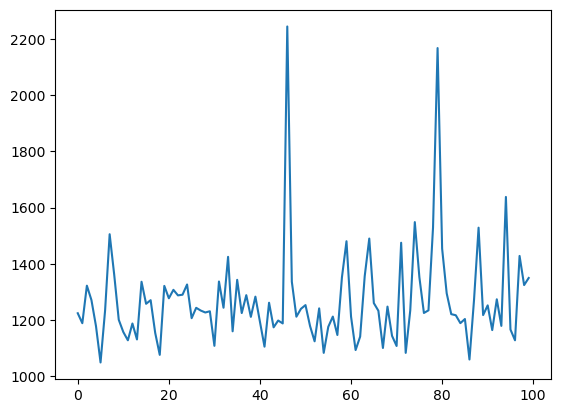

In [45]:
eval_profit=[]
for i in tqdm( range(100)):
    obs,info=train_env.reset()
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        action = agent.compute_single_action(obs,explore=False)
        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = train_env.step(action)

        obs=next_obs

    eval_profit.append(info['portfolio_valuation'])
    info['portfolio_valuation']
profits=[e for e in eval_profit]
plt.plot(profits)
np.mean(profits)

In [46]:
eval_profit=[]
for i in tqdm( range(100)):
    obs,info=test_env.reset()
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        action = agent.compute_single_action(obs,explore=False)
        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = test_env.step(action)

        obs=next_obs

    eval_profit.append(info['portfolio_valuation'])
    info['portfolio_valuation']


  0%|          | 0/100 [00:00<?, ?it/s]

1366.6631060634454

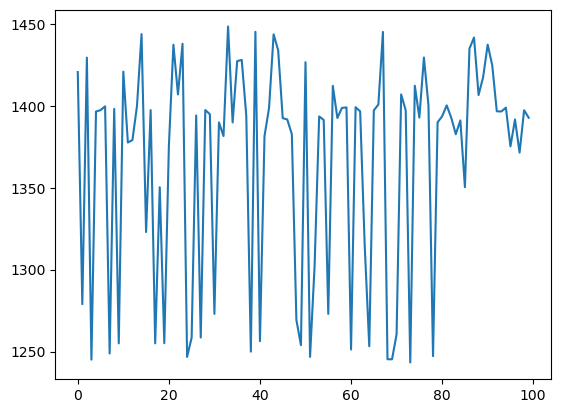

In [47]:

plt.plot(eval_profit)
np.mean(eval_profit)

In [48]:
obs,info=test_env.reset()
action=None
reward=0
terminated = truncated = False

while not terminated and not truncated:

    action = agent.compute_single_action(obs,explore=False)
    # action = train_env.action_space.sample()
    # print(action)
    next_obs, reward, terminated, truncated, info = test_env.step(action)

    obs=next_obs


info['portfolio_valuation']

1391.7871305598828

In [49]:
test_env.save_for_render(dir = "PPO_test_render_logs")

In [52]:
renderer = Renderer(render_logs_dir="PPO_test_render_logs")

In [53]:
# Add Custom Metrics (Annualized metrics)
renderer.add_metric(
    name = "Annual Market Return",
    function = lambda df : f"{ ((df['close'].iloc[-1] / df['close'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)
renderer.add_metric(
        name = "Annual Portfolio Return",
        function = lambda df : f"{((df['portfolio_valuation'].iloc[-1] / df['portfolio_valuation'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)

renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/May/2024 16:56:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2024 16:56:46] "GET /update_data/ETHUSDT_test_2024-05-28_16-27-43.pkl HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2024 16:56:47] "GET /metrics HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2024 16:56:47] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2024 16:56:47] "GET /update_data/ETHUSDT_test_2024-05-28_16-27-43.pkl HTTP/1.1" 200 -
127.0.0.1 - - [28/May/2024 16:56:47] "GET /metrics HTTP/1.1" 200 -
